In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


from estimator_model.deepiv import Net, NetWrapper, DeepIV, MixtureDensityNetwork, MDNWrapper
from estimator_model.utils import BatchData, DiscreteOBatchData

## We divide this notebook into 3 sections, where we
1. ### test Net and NetWrapper in the first section
2. ### test MDN and MDNWrapper in the second section
3. ### test deepiv in the final section.

### Section 1

- continuous input, continuous output

In [2]:
net = Net(x_d=1, w_d=1, out_d=1)
net_wrapped = NetWrapper(net, is_y_net=False)
x = torch.normal(0, 1, size=(1000, 1))
w = torch.ones(1000, 1)

def f(x, w):
    return x * x + torch.exp(x) + 3 * w

target = f(x, w)

net_wrapped.fit(
    x=x,
    w=w,
    target=target,
    device='cpu',
    epoch=10,
)
((net_wrapped.predict(x, w) - f(x, w)) / f(x, w)).mean(dim=0)

Finished 0/10 epochs | current loss 0.7123754620552063
Finished 1/10 epochs | current loss 0.31597843766212463
Finished 2/10 epochs | current loss 0.7384181022644043
Finished 3/10 epochs | current loss 0.8921952247619629
Finished 4/10 epochs | current loss 0.9119081497192383
Finished 5/10 epochs | current loss 0.9053246378898621
Finished 6/10 epochs | current loss 0.8727752566337585
Finished 7/10 epochs | current loss 0.8259055018424988
Finished 8/10 epochs | current loss 0.7809211015701294
Finished 9/10 epochs | current loss 0.7542373538017273


tensor([0.0439], grad_fn=<MeanBackward1>)

- contiuous input, discrete output

In [3]:
out_d = 5
net = Net(x_d=1, w_d=1, out_d=out_d, is_discrete_output=True)
sm = nn.Softmax(dim=1)
loss = nn.CrossEntropyLoss()
result = sm(net(torch.ones(5, 1), torch.randn(5, 1)))
l = loss(result, torch.eye(5, 5))
l.backward()

In [4]:
x = torch.normal(0, 1, size=(1000, 1))
w = torch.normal(1, 2, size=(1000, 1))

def f(x, w):
    xw = torch.cat((x, w), dim=1)
    weight = torch.normal(0, 1, size=(xw.shape[1], 1))
    label_sign = torch.einsum('nd,dc->nc', [xw, weight])
    label = (label_sign > 0).to(int).squeeze()
    return F.one_hot(label)

target = f(x, w)

net = Net(1, 1, 2, is_discrete_output=True)
net_wrapped = NetWrapper(net=net, is_y_net=False)
net_wrapped.fit(x, w, target=target, device='cpu', epoch=20)
# training loss
nn.NLLLoss()(torch.log(net_wrapped.predict_proba(x, w)), torch.argmax(f(x, w), dim=1))

Finished 0/20 epochs | current loss 0.6592088937759399
Finished 1/20 epochs | current loss 0.6291905641555786
Finished 2/20 epochs | current loss 0.6016851663589478
Finished 3/20 epochs | current loss 0.5748964548110962
Finished 4/20 epochs | current loss 0.5489094257354736
Finished 5/20 epochs | current loss 0.5237235426902771
Finished 6/20 epochs | current loss 0.4994180202484131
Finished 7/20 epochs | current loss 0.4757281243801117
Finished 8/20 epochs | current loss 0.4521547853946686
Finished 9/20 epochs | current loss 0.428292453289032
Finished 10/20 epochs | current loss 0.4042879641056061
Finished 11/20 epochs | current loss 0.3802143335342407
Finished 12/20 epochs | current loss 0.35645169019699097
Finished 13/20 epochs | current loss 0.3332989513874054
Finished 14/20 epochs | current loss 0.3108645975589752
Finished 15/20 epochs | current loss 0.28946006298065186
Finished 16/20 epochs | current loss 0.2692394256591797
Finished 17/20 epochs | current loss 0.25034284591674805


tensor(2.5024, grad_fn=<NllLossBackward0>)

- discrete input, discret output

In [5]:
net = Net(x_d=3, w_d=1, out_d=5, is_discrete_input=True, is_discrete_output=True)
sm = nn.Softmax(dim=1)
loss = nn.CrossEntropyLoss()
x_input = torch.randint(0, 3, size=(5,)).squeeze()
w_input = torch.ones(5, 1)
result = sm(net(x_input, w_input))
l = loss(result, torch.eye(5, 5))
l.backward()

In [6]:
x = torch.eye(1000, 5).index_select(dim=0, index=torch.randint(0, 5, size=(1000,)))
w = torch.normal(0, 1, size=(1000, 1))

def f(x, w):
    xw = torch.cat((x, w), dim=1)
    weight = torch.normal(0, 1, size=(xw.shape[1], 1))
    label_sign = torch.einsum('nd,dc->nc', [xw, weight])
    label = (label_sign > 0).to(int).squeeze()
    return F.one_hot(label)

target = f(x, w)

net = Net(x_d=5, w_d=1, out_d=2, is_discrete_output=True, is_discrete_input=True)
net_wrapped = NetWrapper(net)
net_wrapped.fit(x, w, target=target, device='cpu', epoch=10)
nn.NLLLoss()(torch.log(net_wrapped.predict_proba(x, w)), torch.argmax(f(x, w), dim=1))

Finished 0/10 epochs | current loss 0.7128874063491821
Finished 1/10 epochs | current loss 0.6955835223197937
Finished 2/10 epochs | current loss 0.6807866096496582
Finished 3/10 epochs | current loss 0.6674884557723999
Finished 4/10 epochs | current loss 0.6550186276435852
Finished 5/10 epochs | current loss 0.6427129507064819
Finished 6/10 epochs | current loss 0.6300833821296692
Finished 7/10 epochs | current loss 0.6167820692062378
Finished 8/10 epochs | current loss 0.6022742986679077
Finished 9/10 epochs | current loss 0.5861730575561523


tensor(0.7411, grad_fn=<NllLossBackward0>)

- discrete input, continuous output

In [7]:
net = Net(x_d=3, w_d=1, out_d=1, is_discrete_input=True, is_discrete_output=False)
sm = nn.Softmax(dim=1)
loss = nn.MSELoss()
x_input = torch.randint(0, 3, size=(5,)).squeeze()
w_input = torch.ones(5, 1)
result = sm(net(x_input, w_input))
l = loss(result, torch.ones(5, 1))
l.backward()

In [8]:
x = torch.eye(1000, 5).index_select(dim=0, index=torch.randint(0, 5, size=(1000,)))
w = torch.normal(0, 2, size=(1000, 1))

def f(x, w):
    weight = torch.normal(0, 1, size=(6, 1))
    xw = torch.cat((x, w), dim=1)
    target = torch.einsum('nd,dc->nc', [xw, weight])
    return target

target = f(x, w)

net = Net(x_d=5, w_d=1, out_d=1, is_discrete_input=True)
net_wrapped = NetWrapper(net)
net_wrapped.fit(x=x, w=w, target=target, device='cpu', epoch=10)
nn.MSELoss()(net_wrapped.predict(x=x, w=w), target)

Finished 0/10 epochs | current loss 3.2197425365448
Finished 1/10 epochs | current loss 1.407265067100525
Finished 2/10 epochs | current loss 0.6375433206558228
Finished 3/10 epochs | current loss 0.26739564538002014
Finished 4/10 epochs | current loss 0.14910224080085754
Finished 5/10 epochs | current loss 0.09979589283466339
Finished 6/10 epochs | current loss 0.07356016337871552
Finished 7/10 epochs | current loss 0.05659998208284378
Finished 8/10 epochs | current loss 0.04443424195051193
Finished 9/10 epochs | current loss 0.03497590497136116


tensor(0.0389, grad_fn=<MseLossBackward0>)

### Section 2

Test the MDN and MDNWrapper

In [9]:
z_d = 3
w_d = 2
out_d = 1
num_gaussian = 10
mdn = MixtureDensityNetwork(
    z_d=z_d,
    w_d=w_d,
    out_d=out_d,
    num_gaussian=num_gaussian,
    is_discrete_input=False,
)
mdn_wrapped = MDNWrapper(mdn=mdn)

In [10]:
n = 200
z = torch.normal(1, 2, size=(n, z_d))
w = torch.normal(0, 1, size=(n, w_d))
zw = torch.cat((z, w), dim=1)
weight = torch.normal(1, 2, size=(zw.shape[1], 1))
target = torch.distributions.Poisson(torch.exp(zw.matmul(weight))).sample()

In [11]:
# mdn_wrapped.fit(
#     z=z,
#     w=w,
#     target=target,
#     device='cpu',
#     lr=0.2,
#     batch_size=20,
#     epoch=2,
# )

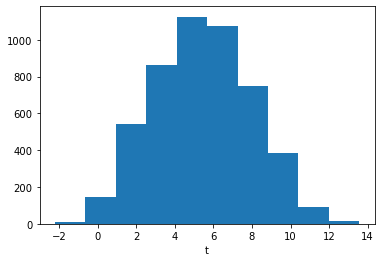

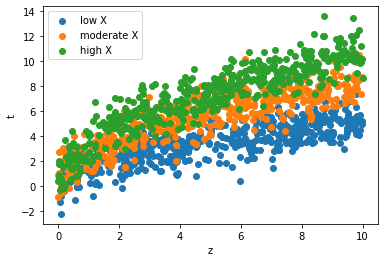

In [12]:
import numpy as np
import matplotlib.pyplot as plt

n = 5000

# Initialize exogenous variables; normal errors, uniformly distributed covariates and instruments
e = np.random.normal(size=(n,))
x = np.random.uniform(low=0.0, high=10.0, size=(n,))
z = np.random.uniform(low=0.0, high=10.0, size=(n,))

# Initialize treatment variable
t = np.sqrt((x+2) * z) + e

# Show the marginal distribution of t
plt.hist(t)
plt.xlabel("t")
plt.show()

plt.scatter(z[x < 1], t[x < 1], label='low X')
plt.scatter(z[(x > 4.5) * (x < 5.5)], t[(x > 4.5) * (x < 5.5)], label='moderate X')
plt.scatter(z[x > 9], t[x > 9], label='high X')
plt.legend()
plt.xlabel("z")
plt.ylabel("t")
plt.show()


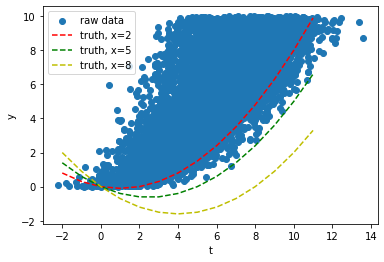

In [13]:
# Outcome equation 
y = t*t / 10 - x*t / 10 + e

# The endogeneity problem is clear, the latent error enters both treatment and outcome equally
plt.scatter(t,z, label ='raw data')
tticks = np.arange(-2,12)
yticks2 = tticks*tticks/10 - 0.2 * tticks
yticks5 = tticks*tticks/10 - 0.5 * tticks
yticks8 = tticks*tticks/10 - 0.8 * tticks
plt.plot(tticks,yticks2, 'r--', label = 'truth, x=2')
plt.plot(tticks,yticks5, 'g--', label = 'truth, x=5')
plt.plot(tticks,yticks8, 'y--', label = 'truth, x=8')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()


In [14]:
import pandas as pd
data_dict = {
    'z': z,
    'w': x,
    'x': t,
    'y': y
}
data = pd.DataFrame(data_dict)

In [15]:
iv = DeepIV(num_gaussian=10)
iv.fit(
    data=data,
    outcome='y',
    treatment='x',
    instrument='z',
    adjustment='w',
    sample_n=5,
    lr=0.1,
    epoch=5,
    device='cpu',
    batch_size=30
)

xtensor([[5.6720, 1.7685],
        [9.4854, 3.2002],
        [2.2416, 0.2310],
        [5.7713, 1.0937],
        [8.5967, 6.1673],
        [7.8645, 4.9438],
        [5.0317, 2.7543],
        [9.9775, 7.8593],
        [8.7194, 8.8799],
        [2.6045, 4.2993],
        [7.7495, 0.6962],
        [5.0512, 7.8073],
        [5.4893, 0.5347],
        [2.6202, 8.4050],
        [2.3646, 0.9746],
        [0.6329, 5.3776],
        [1.8872, 8.6220],
        [8.1406, 0.3094],
        [4.0674, 7.5337],
        [0.4248, 3.4256],
        [0.7686, 8.2518],
        [5.3690, 3.1204],
        [9.9688, 0.5764],
        [1.3101, 9.9565],
        [9.0999, 2.6902],
        [5.7436, 0.4523],
        [4.2929, 1.9008],
        [5.8117, 4.1700],
        [5.3845, 0.4464],
        [5.6490, 7.8354]])
htensor([[1.6411, 1.6854, 1.2285,  ..., 0.3262, 0.5352, 0.7529],
        [1.8795, 2.1074, 1.2271,  ..., 0.1569, 0.3152, 0.6677],
        [1.2817, 1.1973, 1.1326,  ..., 0.6255, 0.8692, 0.8027],
        ...,
        [1.7

ValueError: Expected parameter probs (Tensor of shape (30, 10)) of distribution Categorical(probs: torch.Size([30, 10])) to satisfy the constraint Simplex(), but found invalid values:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<DivBackward0>)